# Attempt to Model Velocity Dependence _with DNNs_
Retry the problem form the previous notebook

In [1]:
%matplotlib inline
import os
import sys
sys.path.append(f"{os.getcwd()}/../")
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.keras import build_fn as build_dense
from stopping_power_ml.integrator import TrajectoryIntegrator

from glob import glob
from tqdm import tqdm_notebook as tqdm

from keras.layers import Dense, Activation, Input
from keras.layers import Concatenate, Multiply, Add
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle as pkl
import numpy as np
import pandas as pd
import keras
import time

dname = "random_models"
randint = 48
keras.utils.set_random_seed(randint)

2024-06-20 16:33:50.175546: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 16:33:50.181182: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 16:33:50.246907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-06-20 16:34:00.316635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load in Data
Read in the random trajectories

In [2]:
data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))

In [3]:
channel_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'channel_traj.pkl')).query('average_range')
random_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [4]:
with open('featurizer.pkl', 'rb') as fp:
    featurizer = pkl.load(fp)

Get the features

In [5]:
X_cols = featurizer.feature_labels()

In [6]:
X_cols_novel = list(X_cols)
X_cols_novel.remove("velocity_mag")
print(X_cols, '\n',X_cols_novel)

['charge density at t=-4.00', 'charge density at t=-3.00', 'charge density at t=-2.00', 'charge density at t=-1.00', 'charge density at t=-0.50', 'charge density at t=0.00', 'charge density at t=0.50', 'charge density at t=1.00', 'charge density at t=2.00', 'AGNI projected eta=8.00e-01', 'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00', 'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00', 'AGNI projected eta=6.80e+00', 'AGNI projected eta=1.04e+01', 'AGNI projected eta=1.60e+01', 'ion-ion repulsion', 'velocity_mag'] 
 ['charge density at t=-4.00', 'charge density at t=-3.00', 'charge density at t=-2.00', 'charge density at t=-1.00', 'charge density at t=-0.50', 'charge density at t=0.00', 'charge density at t=0.50', 'charge density at t=1.00', 'charge density at t=2.00', 'AGNI projected eta=8.00e-01', 'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00', 'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00', 'AGNI projected eta=6.80e+00', 'AGNI proje

In [7]:
X_cols_vel = ["velocity_mag"]

In [8]:
y_col = 'force'

## Create Functions for Building Models
Create functions for building a Keras model

In [9]:
def fit_on_whole_dataset(model, data, callbacks=[], epochs=1, split_v=False):
    """Train a model on the whole dataset
    
    Args:
        model (Model): Model to be trained 
        callbacks ([List]): List of callbacks used during training
        epochs (int): Maximum number of epochs for training
    Returns:
        history - history from the fit
    """

    # Train the model
    if split_v:
        return model.fit([data[X_cols_novel], data[X_cols_vel]], data[y_col], epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        return model.fit(data[X_cols], data[y_col], epochs=epochs, callbacks=callbacks, verbose=0)

def plot_performance(model, split_v):
    """Evaluate and plot the performance of the model on multiple velocities
    
    Args:
        model (keras.Model): Model to be trained
        data (pd.Dataframe): Training set
    """

    # Evaluate on the whole dataset
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_novel], data[X_cols_vel]])
    else:
        data['force_fit'] = model.predict(data[X_cols])

    # Plot results
    fig, axs = plt.subplots(1, 3)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        # Store the velocity
        velocity.append(group['velocity_mag'].mean())
        
        # Plot the performance on a segment of the dataset
        label = 'v={:.1f}'.format(group['velocity_mag'].mean())
        
        for a in axs[:2]:
            my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                                  label=label)

            a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)
            
            a.set_xlabel('Displacement (a.u.)')
            a.set_ylabel('Force ($E_H / a_B$)')
        
        # Select a certain subset
        axs[0].set_xlim(40, 60)
        #ax[0].set_ylim(-0.3, 0.7)
        axs[0].set_yscale('symlog')
        #ax[0].legend(ncol=2)
        
        # Select a certain subset
        axs[1].set_xlim(52, 65)
        axs[1].set_ylim(-0.5, 0.9)
        #ax[1].legend(ncol=2)
        
        # Store the stopping pwoers
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    axs[2].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    axs[2].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    axs[2].set_ylabel('Stopping Power ($E_H / a_B$)')
    axs[2].set_xlabel('Velocity (au.)')
    axs[2].set_ylim(0, max(axs[2].get_ylim()))
    axs[2].set_xlim(0, 4.2)
    axs[2].legend()
    
    fig.set_size_inches(8, 2.5)
    fig.tight_layout()
    
    # Print the MAPE
    stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
    print(f'Mean percent error: {stopping_mape * 100:.2f}%')
    
    return fig, ax, data

In [10]:
input_shape = (len(X_cols_novel),)
v_input_shape = (len(X_cols_vel),)
layers = (input_shape[0],32,24,8,4,3)
v_layers = (v_input_shape[0],3,3)
m_layers = (layers[-1],3)
activation = 'elu'

In [11]:
optimizer_options = {
    'loss': 'mean_absolute_error', 
    'optimizer': Adam(learning_rate=0.0005),
    'metrics': ['mean_absolute_error']
}

In [12]:
callbacks = [EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto'),
             ReduceLROnPlateau('mean_absolute_error')]

### Standard Dense Model
Just treat all layers equally

In [13]:
model = build_dense(len(X_cols), layers, activation=activation, use_linear_block=False,
                   optimizer_options=optimizer_options)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,015 (7.87 KB)

 Trainable params: 2,015 (7.87 KB)

 Non-trainable params: 0 (0.00 B)

## Test on the Whole Dataset
Fit the model on the whole dataset

In [14]:
%%time
dense_history = fit_on_whole_dataset(model, data, callbacks, 3000, False)

CPU times: user 13min 5s, sys: 22.8 s, total: 13min 28s
Wall time: 18min 10s


Plot results

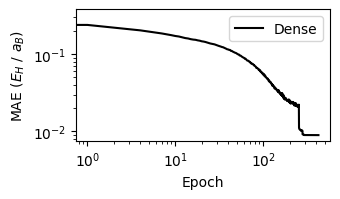

In [15]:
fig, ax = plt.subplots()

ax.loglog(dense_history.epoch, dense_history.history['mean_absolute_error'], 'k', label='Dense')
# ax.loglog(merge_history.epoch, merge_history.history['mean_absolute_error'], 'r', label='Merged')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.legend()

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()
# plt.savefig(f"mae_first{randint}.png", dpi = 300)

## Evaluate Model Performance
Get the performance of the model on the whole dataset

Plot the dense model

   1/1449 ━━━━━━━━━━━━━━━━━━━━ 5:37 233ms/step

  45/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step    

  98/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

 152/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step

 206/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step

 260/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step

 314/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step

 368/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step

 423/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step

 478/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step

 533/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step

 588/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step

 642/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step

 697/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step

 751/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step

 805/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step

 859/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step

 913/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step

 967/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

1021/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

1075/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

1130/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step

1185/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step

1240/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step

1294/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step

1348/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step

1403/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step

1449/1449 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step

1449/1449 ━━━━━━━━━━━━━━━━━━━━ 2s 973us/step


Mean percent error: 0.42%


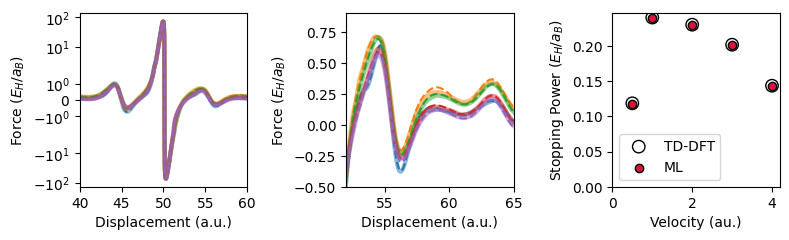

In [16]:
fig, ax, data = plot_performance(model, False)

In [17]:
%%time
channel_data['force_fit'] = model.predict(channel_data[X_cols])

  1/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

 55/137 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step

109/137 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


CPU times: user 255 ms, sys: 5.03 ms, total: 260 ms
Wall time: 362 ms


*Finding*: We agree well with the stopping powers in the channels, so it seems the model is properly cpaturing the difference in stopping power as a function of velocity

In [18]:
train_data = pd.concat([
    pd.read_pickle(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl')),
    pd.read_pickle(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'channel_traj.pkl'))
], sort=False)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
print(model.get_weights()[0].dtype)
callbacks = [keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto'),
             keras.callbacks.ReduceLROnPlateau('mean_absolute_error', min_delta=1e-6)]

float32


In [19]:
%%time
history = model.fit(train_data[featurizer.feature_labels()], train_data['force'], callbacks=callbacks, verbose=0, epochs=1000)
print(model.get_weights()[0].dtype)

float32
CPU times: user 27min 54s, sys: 49.1 s, total: 28min 43s
Wall time: 31min 39s


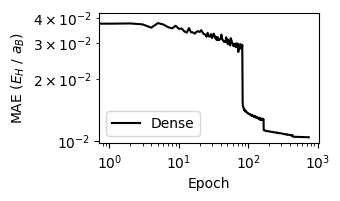

In [20]:
fig, ax = plt.subplots()

ax.loglog(history.epoch, history.history['mean_absolute_error'], 'k', label='Dense')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.legend()

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()
# plt.savefig(f"/mae_second{randint}.png", dpi = 300)

In [21]:
model.save(f'{dname}/model{randint}.h5')

## Make the Trajectory Integration Tool
This will black box the annoying parts of making the trajectories

In [22]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizer)

## Evaluate $\left<100\right>$ at Many Velocities
See how smoothly it varies and whether the difference between channel/not channel increases at higher velocities

In [23]:
channel_stopping = []
for gid, group in channel_data.groupby('directory'):
    channel_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
channel_stopping = pd.DataFrame(channel_stopping)

In [24]:
%%time
# velocities = np.linspace(0.1, 5, 22, endpoint = True)
velocities = np.append(np.linspace(0.1, 0.6, 5, endpoint = True), np.linspace(0.8, 5, 15, endpoint = True))
stopping_power = [
    traj_int.compute_stopping_power([0, 0.75, 0.75], [1, 0, 0], v)[0]
    for v in velocities
]

CPU times: user 1min 20s, sys: 489 ms, total: 1min 20s
Wall time: 1min 20s


## Run the Random Trajectory at Many Velocities
We are going to compute the average stopping power by evaluating the stopping force at every position along the trajectory with different speeds

In [25]:
random_stopping = []
for gid, group in random_data.groupby('directory'):
    random_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
random_stopping = pd.DataFrame(random_stopping)

In [26]:
def compute_random_stopping_power(speed: float) -> float:
    """Compute the stopping power for the random trajectory
    
    Args:
        speed: Magnitude of the velocity
    Returns:
        Stopping power
    """
    start = time.time()
    # Get the positions along the trajectory
    random_positions = random_data[random_data['file'].str.contains('Dv1.0')].copy()
    
    # Update the velocity
    random_positions['velocity'] *= speed
    
    # Run the model
    featurizer.set_chunksize(None)
    x = featurizer.featurize_many(random_positions[['position', 'velocity']], pbar=False)
    forces = model.predict(np.array(x))
    print("executive time", time.time() - start, 's')
    return forces.mean()

In [27]:
%%time
stopping_power_random = [
    compute_random_stopping_power(v)
    for v in velocities
]

  1/294 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step

 52/294 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step

104/294 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step

157/294 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step

211/294 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step

264/294 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


executive time 113.50942850112915 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step

107/294 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step

160/294 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step

214/294 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step

268/294 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


executive time 112.34077167510986 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 53/294 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step

106/294 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step

159/294 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step

211/294 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step

263/294 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


executive time 112.69510412216187 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 50/294 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

103/294 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step

156/294 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step

210/294 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step

264/294 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


executive time 112.92815661430359 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step

108/294 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

162/294 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step

216/294 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step

270/294 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


executive time 112.38448810577393 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

 56/294 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step

110/294 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step

165/294 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step

220/294 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step

275/294 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


executive time 111.57420921325684 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step

108/294 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step

163/294 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step

217/294 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step

272/294 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


executive time 111.58057832717896 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 53/294 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step

107/294 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step

162/294 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step

217/294 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

271/294 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


executive time 105.82358837127686 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step

108/294 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step

162/294 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

217/294 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step

272/294 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


executive time 155.1142725944519 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 55/294 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step

109/294 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step

163/294 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step

218/294 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step

273/294 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


executive time 111.44601154327393 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step

109/294 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step

164/294 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step

219/294 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step

274/294 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


executive time 111.07577633857727 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 55/294 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step

109/294 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step

164/294 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step

218/294 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step

272/294 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


executive time 111.42700123786926 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step

109/294 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step

162/294 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

217/294 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step

271/294 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


executive time 111.42741751670837 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step

108/294 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step

163/294 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step

217/294 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step

272/294 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


executive time 111.2287871837616 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

 55/294 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step

111/294 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step

166/294 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step

221/294 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step

276/294 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


executive time 111.231369972229 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 55/294 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step

111/294 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step

166/294 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step

222/294 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step

277/294 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


executive time 111.44768786430359 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step

109/294 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step

163/294 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step

219/294 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step

273/294 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


executive time 111.33407402038574 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step

108/294 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step

162/294 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step

216/294 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

271/294 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


executive time 111.5027163028717 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

 54/294 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step

109/294 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step

163/294 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step

217/294 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step

271/294 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


executive time 111.44026064872742 s


  1/294 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

 55/294 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step

109/294 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step

164/294 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step

218/294 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step

272/294 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


executive time 111.4714183807373 s
CPU times: user 1min 27s, sys: 2min 22s, total: 3min 50s
Wall time: 37min 53s


In [28]:
np.savetxt(f'{dname}/sp{randint}.dat', np.stack([velocities, stopping_power, stopping_power_random]).T, header = "vel channel random")